In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene detection

What fraction of polyA genes from the annotation do we detect with >= 1 TPM in any library?

In [88]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Number of genes reported: 33635


In [89]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')

In [90]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} ({:.3}%) annotated polyA genes'.format(n_det_polya, n_polya, (n_det_polya/n_polya)*100))

Detected 33635 / 49472 (68.0%) annotated polyA genes


In [91]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname', 'biotype_category']]
df = df.merge(gene_df, how='left', left_index=True, right_on='gid')

df = df[['gid', 'biotype_category']].groupby('biotype_category').count()
df.rename({'gid':'obs_counts'}, axis=1, inplace=True)

gene_df = gene_df[['gid', 'biotype_category']].groupby('biotype_category').count()
gene_df.rename({'gid':'annot_counts'}, axis=1, inplace=True)
df = df.merge(gene_df, how='left', left_index=True, right_index=True)

df['perc'] = (df.obs_counts/df.annot_counts)*100
df = df.sort_values(by='perc', ascending=False)
df

,obs_counts,annot_counts,perc
biotype_category,,,
protein_coding,18805,19969,94.170965
lncRNA,10586,15006,70.545115
pseudogene,4244,14497,29.275022


How many polyA genes do we detect >= 100 TPM in any 1 sample? 

In [17]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, inds = get_tpm_table(df,
                   groupby='sample',
                   how='gene',
                   min_tpm=100,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 100 tpm: 10896
Applying gene type and novelty subset
Averaging over biosample
Found 49 total samples
Number of genes reported: 9917


In [20]:
df.head()

biosample,a673,adipose,adrenal gland,caco2,calu3,colon,gm12878,h1,h1_de,h9,...,ovary,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11
ENSG00000000003.14,91.502783,118.123552,64.993329,347.757386,170.246449,244.050202,0.199761,161.354309,147.109256,215.988595,...,95.081279,15.788161,75.053876,115.327269,121.852699,81.407854,149.271547,74.879355,17.373152,131.196822
ENSG00000000419.12,42.717698,18.387157,34.326836,126.812943,68.914232,18.162833,81.267186,18.462523,22.129494,54.234007,...,18.565741,31.576322,28.866875,35.936605,48.384465,37.407601,37.823395,35.827986,14.561838,22.246875
ENSG00000000460.16,30.518670,1.671560,3.365819,17.822383,40.940526,3.963509,42.876967,44.102917,25.173459,49.930140,...,3.738679,16.419687,3.149114,25.639317,18.341192,2.197551,4.647109,5.210468,3.562550,30.262557
ENSG00000000938.12,0.000000,50.703977,4.205407,0.000000,0.000000,1.995934,83.473252,0.580638,0.000000,0.000000,...,2.752435,0.000000,0.000000,0.000000,1.369208,0.634120,0.830925,0.000000,11.932473,0.738960
ENSG00000000971.15,2.592035,48.475231,31.232974,0.000000,23.877434,18.353658,0.000000,0.000000,0.000000,0.000000,...,221.288445,0.000000,2.624261,3.771192,0.000000,21.303144,32.078505,0.000000,116.995038,0.000000


In [21]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname', 'biotype']]
df = df.merge(gene_df, how='left', left_index=True, right_on='gid')

In [25]:
df.to_csv('polya_genes_100tpm.tsv', sep='\t', index=False)

In [30]:
df = pd.read_csv('polya_genes_100tpm.tsv', sep='\t')

In [32]:
df.loc[df.gname == 'MAP4K4']

,a673,adipose,adrenal gland,caco2,calu3,colon,gm12878,h1,h1_de,h9,...,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11,gid,gname,biotype
733,64.180657,26.187769,8.586867,96.911953,34.056581,20.220004,19.679618,103.745235,117.236845,15.021649,...,53.495081,9.8552,143.535158,42.008378,56.481392,31.355268,90.429202,ENSG00000071054.16,MAP4K4,protein_coding


## How many genes of each biotype category are there in the annotation and detected by us?

In [36]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='gene',
                   min_tpm=1)
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Number of genes reported: 35585


In [37]:
df = df.merge(gene_df, how='left', left_index=True, right_on='gid')
temp = df[['gid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,18805,19969,0.941710
0,lncRNA,10586,15006,0.705451
4,pseudogene,4244,14497,0.292750
2,other,1654,7426,0.222731
1,miRNA,296,1881,0.157363


## How many genes in other biotype categories do we detect and what proportion of the annotation does this represent?

In [38]:
temp = df[['gid', 'biotype', 'biotype_category']].groupby(['biotype', 'biotype_category']).count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_counts, on='biotype', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)

In [39]:
temp

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
20,non_coding,lncRNA,2.0,2,1.000000
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
9,TR_C_gene,other,6.0,6,1.000000
1,IG_C_gene,other,14.0,14,1.000000
17,macro_lncRNA,lncRNA,1.0,1,1.000000
24,protein_coding,protein_coding,18805.0,19969,0.941710
15,bidirectional_promoter_lncRNA,lncRNA,68.0,73,0.931507
23,processed_transcript,lncRNA,539.0,601,0.896839
36,transcribed_unitary_pseudogene,pseudogene,103.0,124,0.830645


Protein coding genes

In [40]:
temp

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
20,non_coding,lncRNA,2.0,2,1.000000
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
9,TR_C_gene,other,6.0,6,1.000000
1,IG_C_gene,other,14.0,14,1.000000
17,macro_lncRNA,lncRNA,1.0,1,1.000000
24,protein_coding,protein_coding,18805.0,19969,0.941710
15,bidirectional_promoter_lncRNA,lncRNA,68.0,73,0.931507
23,processed_transcript,lncRNA,539.0,601,0.896839
36,transcribed_unitary_pseudogene,pseudogene,103.0,124,0.830645


"Other" genes

In [41]:
temp.loc[temp.biotype_category == 'other']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
9,TR_C_gene,other,6.0,6,1.000000
1,IG_C_gene,other,14.0,14,1.000000
8,TEC,other,488.0,1060,0.460377
7,Mt_tRNA,other,10.0,22,0.454545
28,ribozyme,other,3.0,8,0.375000
2,IG_C_pseudogene,other,3.0,9,0.333333
26,rRNA,other,18.0,58,0.310345
12,TR_V_gene,other,30.0,106,0.283019


Psuedogenes

In [42]:
temp.loc[temp.biotype_category == 'pseudogene']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
36,transcribed_unitary_pseudogene,pseudogene,103.0,124,0.830645
37,transcribed_unprocessed_pseudogene,pseudogene,641.0,885,0.724294
35,transcribed_processed_pseudogene,pseudogene,274.0,481,0.569647
38,translated_processed_pseudogene,pseudogene,1.0,2,0.500000
21,polymorphic_pseudogene,pseudogene,20.0,41,0.487805
25,pseudogene,pseudogene,9.0,22,0.409091
39,unitary_pseudogene,pseudogene,28.0,95,0.294737
22,processed_pseudogene,pseudogene,2525.0,10198,0.247598
40,unprocessed_pseudogene,pseudogene,643.0,2649,0.242733


## Differences in lengths of detected vs. non detected genes

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Number of genes reported: 33635


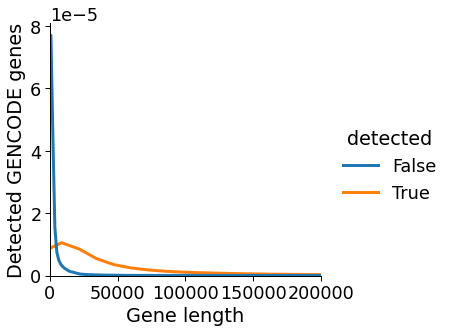

In [43]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='gene', 
                      subset='polya',
                      min_tpm=1,
                      xlim=200000,
                      opref='figures/')

In [44]:
# save this for narges
df.to_csv('det_polya_genes_len.tsv', sep='\t')

## GO on *protein coding* genes that are not detected at >= 1 TPM

In [63]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='gene',
                   min_tpm=1, 
                   gene_subset='polya')
df['detected'] = True

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Number of genes reported: 33635


In [64]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='outer', left_index=True, right_on='gid')
df.detected = df.detected.fillna(False)

In [68]:
print(len(df.index))
df = df.loc[df.biotype_category == 'protein_coding']
print(len(df.index))

58779
19969


In [69]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

,Name,Description
20,hsapiens_gene_ensembl,Human genes (GRCh38.p13)


In [70]:
gids = df.loc[~df.detected, 'gid'].str.rsplit('.', n=1, expand=True)[0].to_frame()
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='undet_genes',
                outdir='undet_genes_GO',
                cutoff=0.5)

2022-03-08 22:36:25,240 Warning: No enrich terms using library GO_Cellular_Component_2021 when cutoff = 0.5


## How many biosamples do we detect each detected gene in?

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Number of genes reported: 33635
Found 49 total samples


biosample,a673,adipose,adrenal gland,caco2,calu3,colon,gm12878,h1,h1_de,h9,...,panc1,pc3,pc9,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,wtc11,n_samples
ENSG00000000003.14,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,40
ENSG00000000005.5,False,True,False,False,False,True,False,True,False,True,...,False,False,False,True,False,True,False,True,True,15
ENSG00000000419.12,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,49
ENSG00000000457.13,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,49
ENSG00000000460.16,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285986.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
ENSG00000285987.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
ENSG00000285988.1,False,False,False,False,True,False,False,True,False,True,...,False,False,True,False,False,False,False,False,True,11
ENSG00000285990.1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,7


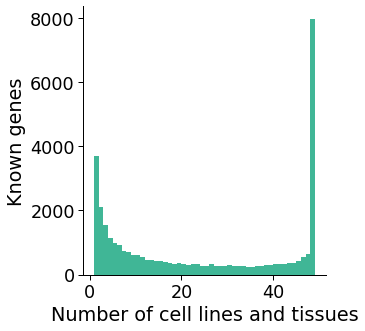

In [71]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
plot_biosamp_det(df,
                 how='gene',
                 min_tpm=1,
                 gene_subset='polya',
                 sample=None,
                 groupby='sample',
                 nov='Known',
                 opref='figures/human')